In [1]:
import argparse
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from utils import *
import numpy as np
import torch
import copy
import matplotlib.patches as patches

In [3]:
sd_mdl = torch.load('out/MNIST_vanilla_RKM_h128_oneview.tar', map_location=torch.device('cpu'))
#out/MNIST_vanilla_RKM_h128_oneview.tar
#out/MNIST_adv_linf_RKM_h_500.tar

net1 = sd_mdl['net1'].float().cpu()
net3 = sd_mdl['net3'].float().cpu()
net2 = sd_mdl['net2'].float().cpu()
net4 = sd_mdl['net4'].float().cpu()
net1.load_state_dict(sd_mdl['net1_state_dict'])
net3.load_state_dict(sd_mdl['net3_state_dict'])
net2.load_state_dict(sd_mdl['net2_state_dict'])
net4.load_state_dict(sd_mdl['net4_state_dict'])
h = sd_mdl['h'].float().detach().cpu()
s = sd_mdl['s'].float().detach().cpu()
V = sd_mdl['V'].float().detach().cpu()
U = sd_mdl['U'].float().detach().cpu()

sd_mdl_ = torch.load('out/MNIST_adv_RKM_h128_epoch200_pert30_oneview.tar', map_location=torch.device('cpu'))

net1_ = sd_mdl_['net1'].float().cpu()
net3_ = sd_mdl_['net3'].float().cpu()
net2_ = sd_mdl_['net2'].float().cpu()
net4_ = sd_mdl_['net4'].float().cpu()
net1_.load_state_dict(sd_mdl_['net1_state_dict'])
net3_.load_state_dict(sd_mdl_['net3_state_dict'])
net2_.load_state_dict(sd_mdl_['net2_state_dict'])
net4_.load_state_dict(sd_mdl_['net4_state_dict'])
h_ = sd_mdl_['h'].float().detach().cpu()
s_ = sd_mdl_['s'].float().detach().cpu()
V_ = sd_mdl_['V'].float().detach().cpu()
U_ = sd_mdl_['U'].float().detach().cpu()

In [4]:
# Load a Pre-trained model or saved model ====================
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--filename', type=str, default="out/MNIST_adv_linf_RKM_h_500.tar", help='Enter Filename')
parser.add_argument('--device', type=str, default='cpu', help='Device type: cuda or cpu')
opt_gen = parser.parse_args()

if 'opt' in sd_mdl:
    opt = sd_mdl['opt']
    #self.opt_gen = argparse.Namespace(**vars(opt), **vars(self.opt_gen))
    opt_dict = vars(opt)
    opt_dict.update(vars(opt_gen))  # Update opt_gen with values from opt, prioritizing opt_gen
    opt_gen = argparse.Namespace(**opt_dict)
else:
    opt_gen.mb_size = 200
    
#load the data
opt_gen.shuffle = False
xt, _, _ = get_mnist_dataloader(args=opt_gen)  # loading data without shuffle
xtrain = xt.dataset.train_data[:h.shape[0], :, :, :]  #60.000, 1, 28, 28; h shape 0: 5000
ytrain = xt.dataset.targets[:h.shape[0], :]

image_ori = xtrain[0, :, :, :].float()

c:\Users\gcorl\OneDrive\Documents\KUL\Master 2\Master thesis\Programming\Restricted_Kernel_Machines_Demo_MNIST\myenv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [5]:
#go to the feature space
image_ori = xtrain[0, :, :, :].float()
print(image_ori.shape)
image_ori = image_ori[None, :, :, :]
assert image_ori.shape == (1, 1, 28, 28)

output1 = net1(image_ori)

print(output1.shape)

#compute (Lambda-V_T*V)^-1
#VT_V = torch.mm(V.T, V)
Lambda = torch.diag(s[:h.size(1)])
#lam_VTV = torch.linalg.inv(Lambda-VT_V)
lam_inv = torch.linalg.inv(Lambda)

print(f"output1 {output1.shape}")
print(f"U {U.shape}")
print(f"lam_inv {lam_inv.shape}")

#compute h = (Lambda-V_T*V)^-1*U_T*net1(x)
#note here the computation is done with everything transposed
latent1 = torch.mm(torch.mm(output1, U),lam_inv.T)
#latent1 = torch.mm(torch.mm(output1, U),lam_VTV.T)


#go back to the feature space U*h
my_input_net3 = torch.mm(latent1, torch.t(U))

#go back to the image space
datax_gen = net3(my_input_net3[0,:])

torch.Size([1, 28, 28])
torch.Size([1, 128])
output1 torch.Size([1, 128])
U torch.Size([128, 128])
lam_inv torch.Size([128, 128])


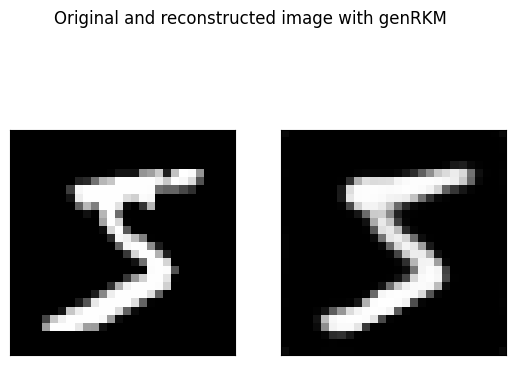

In [6]:
#image_ori_gen = self.__generate_back(self.image_ori)
image_ori_gen = datax_gen.reshape(1, 28, 28)

model_name = "genRKM"

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_ori[0, 0, :], cmap='Greys_r', vmin=0, vmax=1)
ax[1].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.show()

In [7]:
#go to the feature space
image_ori = xtrain[0, :, :, :].float()
print(image_ori.shape)
image_ori = image_ori[None, :, :, :]
assert image_ori.shape == (1, 1, 28, 28)

output1_ = net1_(image_ori)

print(output1_.shape)

#compute (Lambda-V_T*V)^-1
#VT_V = torch.mm(V.T, V)
Lambda_ = torch.diag(s_[:h_.size(1)])
#lam_VTV = torch.linalg.inv(Lambda-VT_V)
lam_inv_ = torch.linalg.inv(Lambda_)

print(f"output1 {output1_.shape}")
print(f"U {U_.shape}")
print(f"lam_inv {lam_inv.shape}")

#compute h = (Lambda-V_T*V)^-1*U_T*net1(x)
#note here the computation is done with everything transposed
latent1_ = torch.mm(torch.mm(output1_, U_),lam_inv_.T)
#latent1 = torch.mm(torch.mm(output1, U),lam_VTV.T)


#go back to the feature space U*h
my_input_net3_ = torch.mm(latent1_, torch.t(U_))

#go back to the image space
datax_gen_ = net3_(my_input_net3_[0,:])

torch.Size([1, 28, 28])
torch.Size([1, 128])
output1 torch.Size([1, 128])
U torch.Size([128, 128])
lam_inv torch.Size([128, 128])


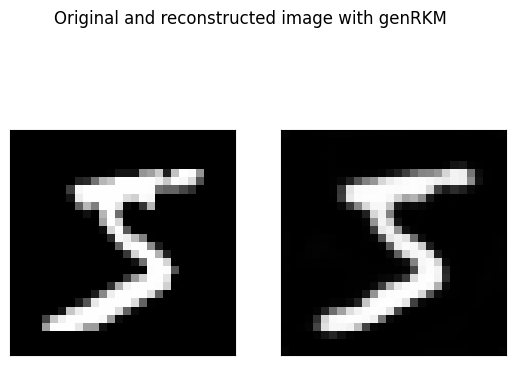

In [9]:
#image_ori_gen = self.__generate_back(self.image_ori)
image_ori_gen_ = datax_gen_.reshape(1, 28, 28)

model_name = "genRKM"

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_ori[0, 0, :], cmap='Greys_r', vmin=0, vmax=1)
ax[1].imshow(image_ori_gen_[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.show()